### 7. LightGBM

- XGBoost에 비해 학습에 걸리는 시간과 메모리 사용량은 상대적으로 적지만 예측 성능은 큰 차이가 없음
- 기능상 XGBoost보다 약간 더 다양함
- 카테고리형 피처의 자동 변환과 이에 따른 최적 노드 분할
- 대용량 데이터에 대한 뛰어난 예측 성능 및 병렬 컴퓨팅 기능 제공
- GPU 지원
- 적은 데이터 세트에 적용할 경우 과적합 발생하기 쉬움(10,000건 이하)
- 파이썬 래퍼용만 개발됐으나 사이킷런 래퍼 LightGBM이 추가로 개발됨


- 리프 중심 트리 분할(Leaf Wise)방식 사용
    - 최대 손실값(max delta loss)를 가지는 리프 노드를 지속적으로 분할하면서 트리 깊이 깊어지고 비대칭적 규칙 트리 생성
    - 학습을 반복할수록 균형 트리 분할 방식보다 예측 오류 손시 최소화할 수 있음
    

- 기존 대부분 트리 기반 알고리즘은 균형 트리 분할(Level Wise)방식 사용
    - 최대한 균형 잡힌 트리를 유지하면서 분할하므로 트리의 깊이 최소화
    - 오버피팅에 보다 더 강한 구조 but 균형을 맞추기 위한 시간 필요
    
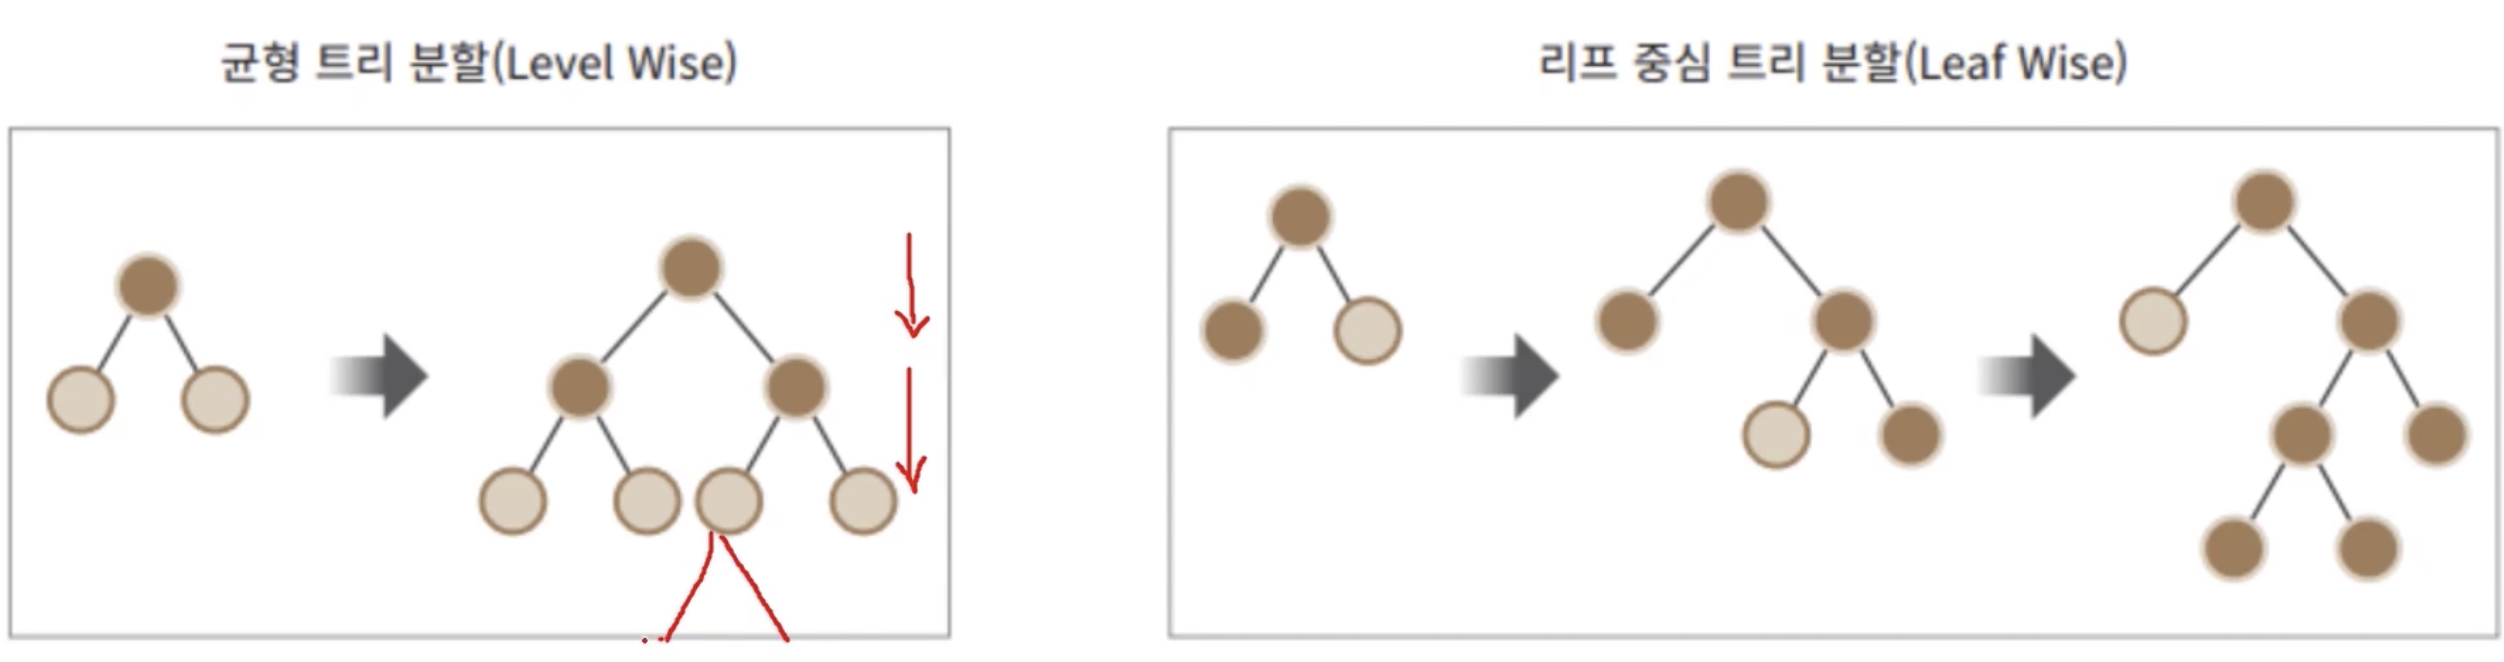

#### LightGBM 하이퍼 파라미터

|파라미터|기본값|설명|
|---|:---:|---:|
|`num_iterations`|100|반복 수행하려는 트리 개수 지정/클 수록 예측 성능 높일 수 있으나 너무 크면 과적합으로 성능 저하|
|`learning_rate`|0.1|0~1사이 값으로 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값/n_estimators를 크게하고 learning_rate를 작게해서 예측 성능 향상시킬 수 있으나 과적합 이슈와 학습시간 길어질 수 있음|
|`max_depth`|-1|0보다 작은 값 지정하면 깊이에 제한 없음|
|`min_data_in_leaf`|20|리프노드가 되기 위한 최소한으로 필요한 레코드 수/과적합 제어|
|`num_leaves`|31|하나의 트리가 가질 수 있는 최대 리프 개수|
|`boosting`|gbdt|부스팅 트리를 생성하는 알고리즘 기술 / gbdt:그래디언트부스팅,rf:랜덤포레스트|
|`bagging_fraction`|1.0|데이터 샘플링하는 비율 지정/과적합 제어|
|`feature_fraction`|1.0|개별 트리 학습시마다 무작위로 선택하는 피처 비율/과적합 제어|
|`lambda_l2`|0.0|L2 regularization 제어 위한 값/피처 개수 많을 시 적용 검토/ 클수록 과적합 감소 효과|
|`lambda_l1`|0.0|L1 regularization 제어 위한 값/ 클수록 과적합 감소 효과|
|`objective`|**Learning Task 파라미터**|최소값을 가져야 할 손실함수 정의|

#### 하이퍼 파라미터 튜닝 방안
- 기본 튜닝 방안   
    - num_leaves의 개수 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정해 보델 복잡도 줄이기
- 부스팅 계열 튜닝에서 기본 튜닝 방안
    - learning_rate 작게 하면서 n_estimators 크게 하기
    - n_estimators가 너무 크면 과적합 가능성 있음
- 과적합 제어
    - reg_lambda, reg_alpha 같은 regularization 적용
    - colsample_bytree, subsample 파라미터 적용해 학습 데이터에 사용할 피처 개수나 데이터 샘플링 레코드 개수 줄이기

#### 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교
|파이썬 래퍼 LightGBM|사이킷런 래퍼 LightGBM| 사이킷런 래퍼 XGBoost|
|---|:---:|---:|
|num_iterations|n_estimators|n_estimators|
|learning_rate|learning_rate|learning_rate|
|max_depth|max_depth|max_depth|
|min_data_in_leaf|min_child_samples|N/A
|bagging_fraction|subsample|subsample|
|feature_fraction|colsample_bytree|colsample_bytree
|lambda_l2|reg_lambda|reg_lambda
|lambda_l1|reg_alpha|reg_alpha
|early_stopping_round|early_stopping_rounds|early_stopping_rounds
|num_leaves|num_leaves|N/A
|min_sum_hessian_in_leaf|min_child_weight|min_child_weight

#### LightGBM 적용 - 위스코신 유방암 예측

In [2]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score, f1_score,confusion_matrix

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X_features, y_label, test_size=0.2, random_state =156)

X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# 조기 중단 수행
evals = [(X_tr, y_tr),(X_val,y_val)]
lgbm_wrapper.fit(X_tr,y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

C:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC:0.9877


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

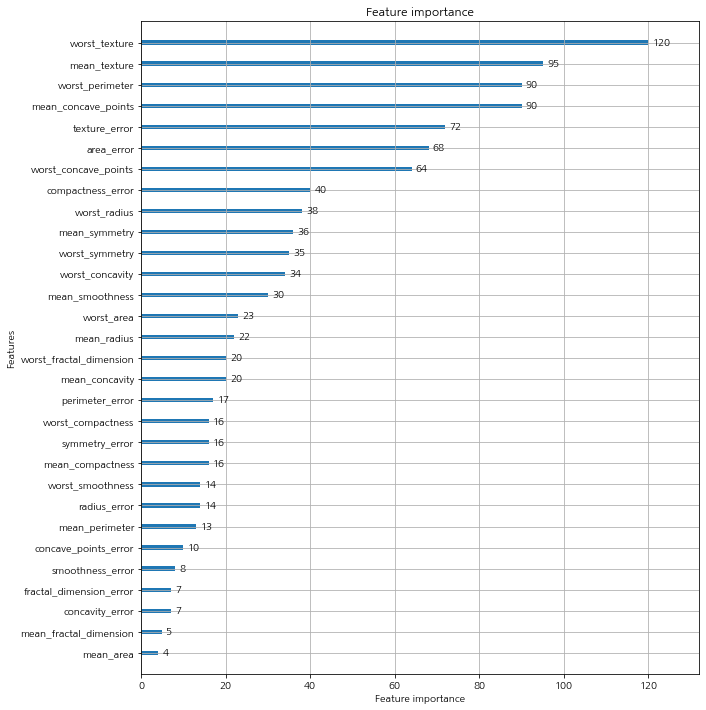

In [6]:
# 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

### 8. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

- Grid Search는 튜닝할 하이퍼 파라미터 개수가 많을 경우 최적화 수행 시간이 오래걸림
- 개별 하이퍼 파라미터 값의 범위가 넓거나 학습 데이터가 대용량일 경우 더욱 늘어남
- 실무의 대용량 학습 데이터에 XGBoost나 LightGBM의 하이퍼 파라미터 튜닝 시에는 베이지안 최적화 기법 사용

#### 베이지안 최적화 개요
- 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
- 베이지안 확률에 기반을 두고 있는 최적화 기법
- 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해나가며 최적 함수 모델 생성

**중요 구성 요소**
- 대체 모델(Surrogate Model)
    - 획득 함수로부터 최적 함수를 예측할 수 있는 입력값 추천 받은 뒤 이를 기반으로 최적 함수 모델 개선
- 획득 함수(Acquisition Function)
    - 개선된 대체 모델을 기반으로 최적 입력값 계산
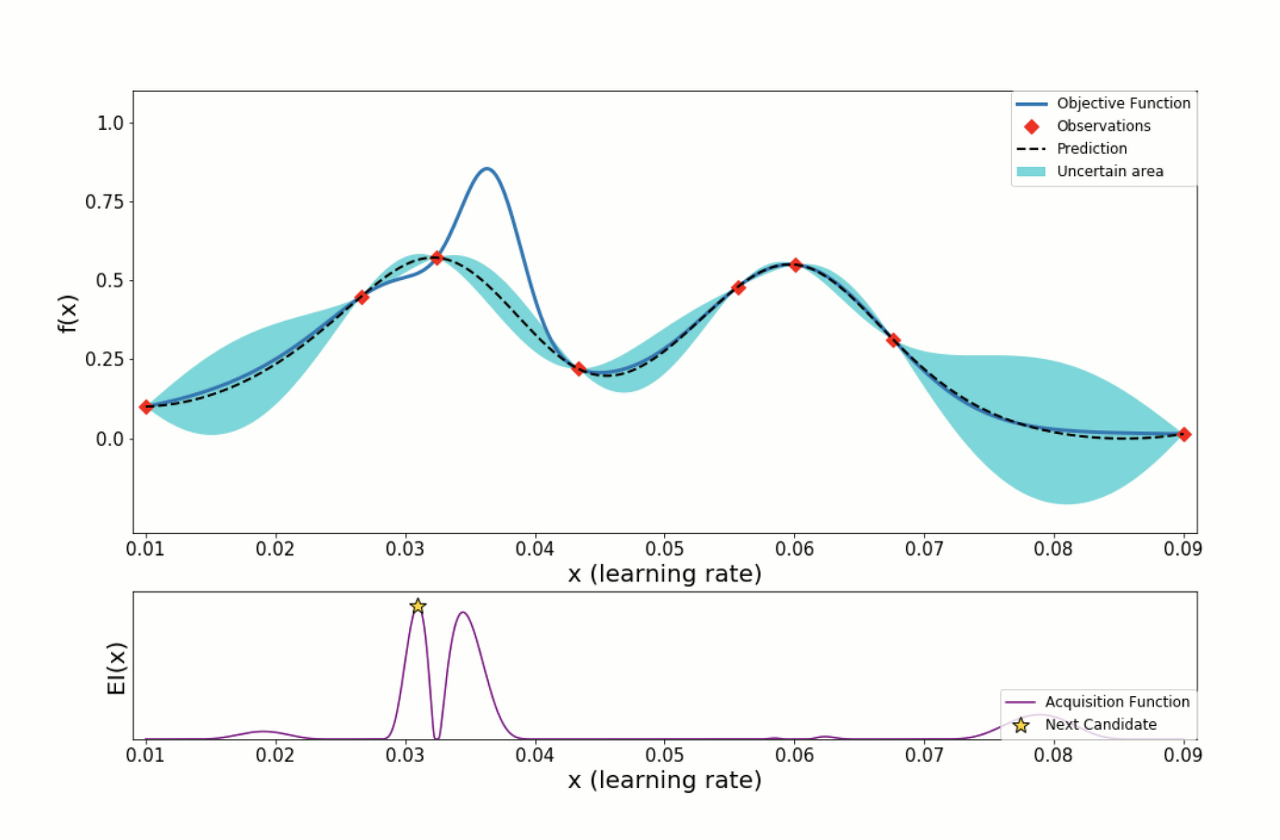
1. 최초에 랜덤하게 하이퍼 파라미터들 샘풀링하고 성능 결과 관측
    - 파란색 선은, 우리가 찾으려고 하는 목표 최적 함수 f(x) 를 나타냄
2. 관측값 기반으로 대체 모델은 최적 함수 추정
    - 검정색 점선은, 지금까지 관측한 데이터를 바탕으로 우리가 예측한 estimated function 을 의미
    - 검정색 점선 주변에 있는 파란 영역은, 목적함수 f(x) 가 존재할만한 신뢰 구간(function의 variance)를 의미, 추정 함수의 불확실성 나타냄
    - y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터 -> 최적 관측값
3. 추정된 최적 함수를 기반으로 획득 함수 EI(x)로 다음 관측할 하이퍼 파라미터 값 계산
    - 이전 최적 관측값보다 더 큰 최대값을 가질 가능성이 있는 높은 지점 찾아 다음에 관측할 하이퍼 파라미터 대체 모델에 전달
    - Acquisition function 값이 컸던 지점을 확인하고, 해당 지점의 hyperparameter 를 다음 입력 값으로 사용
4. 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값 기반으로 대체 모델 갱신되고 다시 최적 함수 예측 추정
    - hyperparamter 에 따라 estimated function 을 계속 갱신 하면, estimation function 과 목적 함수 f(x) 가 흡사해짐
    - 모델 불확실성 개선됨
- 대체 모델이 최적 함수 추정 시 일반적으로 가우시안 프로세스 적용
- HyperOpt는 트리 파르젠 Estimator(TPE, Tree-structure Parzen Estimator) 사용

#### HyerOpt 사용하기
- 활용 주요 로직
    1. 입력 변수명과 입력값의 검색 공간 설정 / 파이썬 딕셔너리 형태로 설정되야함 (키:입력 변수명, value:해당 입력 변수의 검색 공간)
    2. 목적 함수 설정 / 변수값과 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정값 반환하는 구조로 만들어야함
    3. 목적 함수의 반환 최소값을 가지는 최적 입력값 유추 / fmin() 함수 사용

In [9]:
# hp 모듈 : 입력값의 검색 공간 다양하게 설정할 수 있도록 함수 제공
from hyperopt import hp
# -10 ~ 10까지 1간격 가지는 입력 변수 x와 -15~15까지 1간격으로 입력 변수 y 설정
search_space = {'x':hp.quniform('x',-10,10,1),'y':hp.quniform('y',-15,15,1)}

In [10]:
# 목적 함수 생성
from hyperopt import STATUS_OK

# 딕셔너리 형태로 반환 시 loss와 status키 값 설정해서 반환해야 함
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

**fmin 함수 주요 인자**

|인자명|설명|
|---|---:|
|`fn`|목적 함수|
|`space`|검색 공간 딕셔너리|
|`algo`|베이지안 최적화 전용 알고리즘/기본적으로 tpe.suggest|
|`max_evals`|최적 입력값 찾기 위한 입력값 시도 횟수|
|`trials`|최적 입력값 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과 저장|
|`rstate`|fmin()수행할 때마다 동일한 결과값 가질 수 있도록 설정하는 랜덤 시드, 일반적으로 잘 적용 안함|

In [12]:
from hyperopt import fmin, tpe, Trials
# 입력 결과값 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최소값 반환하는 최적 입력 변수값을 5번의 입력값 시도로 찾아냄
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,
              trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 250.70trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [13]:
# max_evals 20으로 설정
trial_val = Trials()

# 목적 함수의 최소값 반환하는 최적 입력 변수값을 5번의 입력값 시도로 찾아냄
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,
              trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_02)

100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 339.88trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [14]:
trial_val.results # 목적 함수 반환값

[{'loss': -64.0, 'status': 'ok'},
 {'loss': -184.0, 'status': 'ok'},
 {'loss': 56.0, 'status': 'ok'},
 {'loss': -224.0, 'status': 'ok'},
 {'loss': 61.0, 'status': 'ok'},
 {'loss': -296.0, 'status': 'ok'},
 {'loss': -40.0, 'status': 'ok'},
 {'loss': 281.0, 'status': 'ok'},
 {'loss': 64.0, 'status': 'ok'},
 {'loss': 100.0, 'status': 'ok'},
 {'loss': 60.0, 'status': 'ok'},
 {'loss': -39.0, 'status': 'ok'},
 {'loss': 1.0, 'status': 'ok'},
 {'loss': -164.0, 'status': 'ok'},
 {'loss': 21.0, 'status': 'ok'},
 {'loss': -56.0, 'status': 'ok'},
 {'loss': 284.0, 'status': 'ok'},
 {'loss': 176.0, 'status': 'ok'},
 {'loss': -171.0, 'status': 'ok'},
 {'loss': 0.0, 'status': 'ok'}]

In [15]:
trial_val.vals # 입력 변수 값

{'x': [-6.0,
  -4.0,
  4.0,
  -4.0,
  9.0,
  2.0,
  10.0,
  -9.0,
  -8.0,
  -0.0,
  -0.0,
  1.0,
  9.0,
  6.0,
  9.0,
  2.0,
  -2.0,
  -4.0,
  7.0,
  -0.0],
 'y': [5.0,
  10.0,
  -2.0,
  12.0,
  1.0,
  15.0,
  7.0,
  -10.0,
  0.0,
  -5.0,
  -3.0,
  2.0,
  4.0,
  10.0,
  3.0,
  3.0,
  -14.0,
  -8.0,
  11.0,
  -0.0]}

In [16]:
# DataFrame으로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

result_df = pd.DataFrame({'x':trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


#### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화
- HyperOpt는 입력값과 반환 값이 모두 실수형이기 때문에 하이퍼 파라미터 입력 시 형변환 필요
- HyperOpt의 목적 함수는 최소값을 반환할 수 있도록 최적화해야 하므로 성능 값이 클수록 좋은 지표일 경우 -1 곱해줘야함
    - ex) 정확도 ↔ MAE, RMSE 등은 -1 곱할 필요 없음

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr,X_val,y_tr,y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [18]:
xgb_search_space = {'max_depth':hp.quniform('max_depth',5,20,1),
                   'min_child_weight':hp.quniform('min_child_weight',1,2,1),
                   'learning_rate':hp.uniform('learning_rate',0.01,0.2),
                   'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

In [20]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate=search_space['learning_rate'],
                           colsample_bytree=search_space['colsample_bytree'],
                           eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    return {'loss':-1*np.mean(accuracy), 'status':STATUS_OK}

In [23]:
trial_val = Trials()
best = fmin(fn=objective_func, space=xgb_search_space,
           algo=tpe.suggest, max_evals=50, trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:',best)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  2%|▉                                               | 1/50 [00:00<00:22,  2.16trial/s, best loss: -0.9472958057395143]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  4%|█▉                                              | 2/50 [00:00<00:21,  2.28trial/s, best loss: -0.9604827466016034]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  6%|██▉                                             | 3/50 [00:01<00:20,  2.33trial/s, best loss: -0.9604827466016034]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  8%|███▊                                            | 4/50 [00:01<00:19,  2.32trial/s, best loss: -0.9604827466016034]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 10%|████▊                                           | 5/50 [00:02<00:18,  2.46trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 12%|█████▊                                          | 6/50 [00:02<00:17,  2.51trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 14%|██████▋                                         | 7/50 [00:02<00:17,  2.46trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 16%|███████▋                                        | 8/50 [00:03<00:17,  2.44trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 18%|████████▋                                       | 9/50 [00:03<00:16,  2.49trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 20%|█████████▍                                     | 10/50 [00:04<00:16,  2.39trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 22%|██████████▎                                    | 11/50 [00:04<00:15,  2.44trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 24%|███████████▎                                   | 12/50 [00:04<00:15,  2.48trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 26%|████████████▏                                  | 13/50 [00:05<00:14,  2.57trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 28%|█████████████▏                                 | 14/50 [00:05<00:14,  2.42trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 30%|██████████████                                 | 15/50 [00:06<00:14,  2.36trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 32%|███████████████                                | 16/50 [00:06<00:14,  2.39trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 34%|███████████████▉                               | 17/50 [00:07<00:15,  2.10trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 36%|████████████████▉                              | 18/50 [00:07<00:14,  2.20trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 38%|█████████████████▊                             | 19/50 [00:08<00:14,  2.20trial/s, best loss: -0.9626612059951203]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 40%|███████████████████▏                            | 20/50 [00:08<00:13,  2.28trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 42%|████████████████████▏                           | 21/50 [00:08<00:12,  2.26trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 44%|█████████████████████                           | 22/50 [00:09<00:12,  2.26trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 46%|██████████████████████                          | 23/50 [00:09<00:11,  2.40trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 48%|███████████████████████                         | 24/50 [00:10<00:11,  2.25trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 50%|████████████████████████                        | 25/50 [00:10<00:11,  2.18trial/s, best loss: -0.964868711513884]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 52%|████████████████████████▍                      | 26/50 [00:11<00:10,  2.29trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 54%|█████████████████████████▍                     | 27/50 [00:11<00:09,  2.33trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 56%|██████████████████████████▎                    | 28/50 [00:11<00:09,  2.25trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 58%|███████████████████████████▎                   | 29/50 [00:12<00:08,  2.36trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 60%|████████████████████████████▏                  | 30/50 [00:12<00:08,  2.25trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 62%|█████████████████████████████▏                 | 31/50 [00:13<00:08,  2.14trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 64%|██████████████████████████████                 | 32/50 [00:13<00:08,  2.15trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 66%|███████████████████████████████                | 33/50 [00:14<00:07,  2.31trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 68%|███████████████████████████████▉               | 34/50 [00:14<00:06,  2.34trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 70%|████████████████████████████████▉              | 35/50 [00:15<00:06,  2.30trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 72%|█████████████████████████████████▊             | 36/50 [00:15<00:06,  2.31trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 74%|██████████████████████████████████▊            | 37/50 [00:15<00:05,  2.27trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 76%|███████████████████████████████████▋           | 38/50 [00:16<00:05,  2.16trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 78%|████████████████████████████████████▋          | 39/50 [00:16<00:05,  2.16trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 80%|█████████████████████████████████████▌         | 40/50 [00:17<00:04,  2.14trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 82%|██████████████████████████████████████▌        | 41/50 [00:17<00:04,  2.20trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 84%|███████████████████████████████████████▍       | 42/50 [00:18<00:03,  2.24trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 86%|████████████████████████████████████████▍      | 43/50 [00:18<00:02,  2.35trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 88%|█████████████████████████████████████████▎     | 44/50 [00:18<00:02,  2.40trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 90%|██████████████████████████████████████████▎    | 45/50 [00:19<00:02,  2.33trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 92%|███████████████████████████████████████████▏   | 46/50 [00:19<00:01,  2.41trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 94%|████████████████████████████████████████████▏  | 47/50 [00:20<00:01,  2.49trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 96%|█████████████████████████████████████████████  | 48/50 [00:20<00:00,  2.55trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 98%|██████████████████████████████████████████████ | 49/50 [00:21<00:00,  2.45trial/s, best loss: -0.9670616939700244]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|███████████████████████████████████████████████| 50/50 [00:21<00:00,  2.33trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [24]:
print('colsample_bytree:{0}, learning_rate:{1}, min_child_weight:{3}'.format(round(best['colsample_bytree'],5),
                                                                            round(best['learning_rate'],5),
                                                                            int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.54241, learning_rate:0.12601, min_child_weight:2


In [29]:
# 도출된 최적 하이퍼 파라미터로 XGBClassifier 재학습 후 성능 평가
xgb_wrapper = XGBClassifier(n_estimators= 400, max_depth=int(best['max_depth']),
                           min_child_weight=int(best['min_child_weight']),
                           learning_rate=round(best['colsample_bytree'],5),
                           colsample_bytree=round(best['colsample_bytree'],5))
evals = [(X_tr, y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.33704	validation_1-logloss:0.46145
[1]	validation_0-logloss:0.19944	validation_1-logloss:0.39298
[2]	validation_0-logloss:0.13024	validation_1-logloss:0.34734
[3]	validation_0-logloss:0.09372	validation_1-logloss:0.32993
[4]	validation_0-logloss:0.06697	validation_1-logloss:0.30786
[5]	validation_0-logloss:0.05531	validation_1-logloss:0.32012
[6]	validation_0-logloss:0.04739	validation_1-logloss:0.31073
[7]	validation_0-logloss:0.04110	validation_1-logloss:0.30579
[8]	validation_0-logloss:0.03403	validation_1-logloss:0.28622
[9]	validation_0-logloss:0.03033	validation_1-logloss:0.28585
[10]	validation_0-logloss:0.02733	validation_1-logloss:0.28478
[11]	validation_0-logloss:0.02550	validation_1-logloss:0.27399
[12]	validation_0-logloss:0.02463	validation_1-logloss:0.26693
[13]	validation_0-logloss:0.02306	validation_1-logloss:0.27336
[14]	validation_0-logloss:0.02225	validation_1-logloss:0.28350
[15]	validation_0-logloss:0.02149	validation_1-logloss:0.28218
[1

In [31]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[33  4]
 [ 3 74]]
정확도: 0.9386, 정밀도: 0.9487, 재현율: 0.9610, F1: 0.9548, AUC:0.9905


### 9. 분류 실습 - 캐글 산탄데르 고객 만족 예측

### 10. 분류 실습 - ㅅ